In [167]:
from System_matrix import N_layer_system, N_layer_system_tilted_2
from System_solve import solve_N_layer, solve_Temps
from Real_atmosphere import read_atmosphere
from E_in_Ozone import Ozone_absorption_constant_253K_P, Sun_E_bands,E_abs_O
from plotting import plot_layers, plot_flux, plot_sun_spectrum,plot_E_abs_O,plot_profile_atmosphere
from CO2_epsilon import CO2_absorption_coefficient
from Fluxes import fluxes_N_layer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## get real atmosphere data
z_interp, O3_interp, T_real, p_real, n_air,H2Oppm= read_atmosphere(file="Standard_Atmospheres/US_standard.csv",height=50,dz=1000)
mid_air=n_air[:-1]+np.diff(n_air)/2
mid_H2Oppm=H2Oppm[:-1]+np.diff(H2Oppm)/2
mid_preal=p_real[:-1]+np.diff(p_real)/2
mid_Treal=T_real[:-1]+np.diff(T_real)/2
CO2ppm=np.ones(len(mid_H2Oppm))*400

alpha_CO2=np.loadtxt("CO2_ppm400_spec100000_4um_100um_N50_US.csv", delimiter=",")
alpha_H2O=np.loadtxt("H2O_ppm400_spec100000_4um_100um_N50_US.csv", delimiter=",")
Band_interval=np.linspace(4,100,100000)

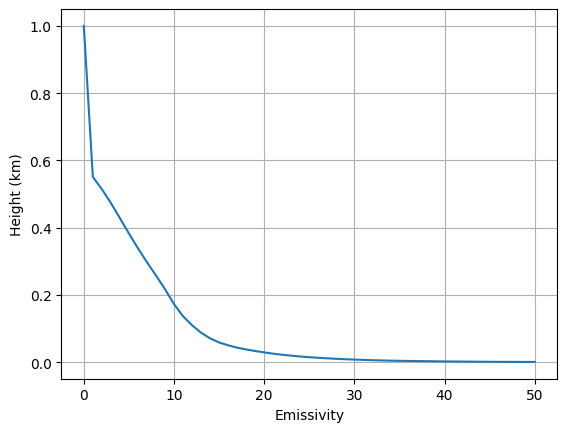

[1.         0.55130811 0.51452703 0.47360728 0.42854001 0.38309189
 0.33906239 0.29763858 0.25814213 0.21752033 0.17297653 0.13697235
 0.11009102 0.08802184 0.07115253 0.05903567 0.05054512 0.04368178
 0.03826417 0.03361845 0.02944336 0.02571976 0.0225029  0.01973304
 0.01728034 0.01513219 0.01343362 0.01186641 0.01042517 0.00925333
 0.00817083 0.0071496  0.00631152 0.00554733 0.0049363  0.0044322
 0.00403789 0.00369339 0.00334322 0.00301554 0.00269312 0.00241534
 0.00219071 0.0019711  0.00177965 0.00159951 0.00143959 0.00130463
 0.00119775 0.00116064 0.00116064]


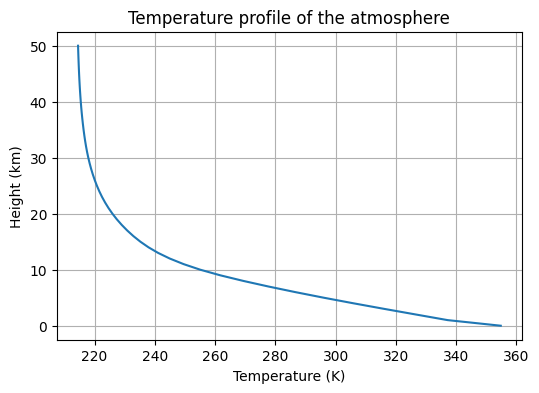

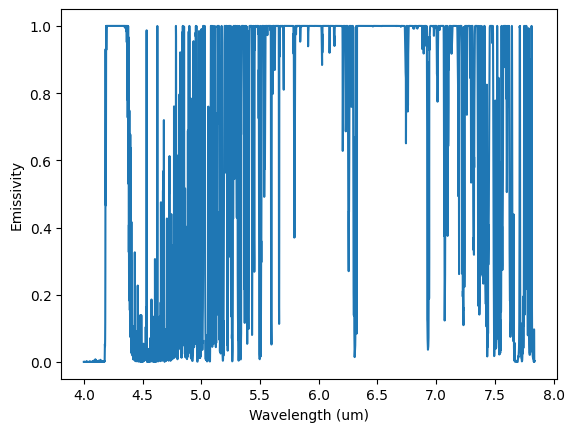

2.0062915403001696e-19


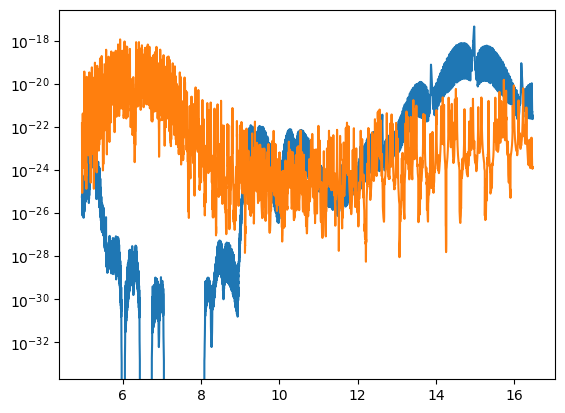

In [168]:
###Grey scale temperature profile

def planck_spec(T_surface,Band_centers): #
    h  = 6.62607015e-34      # Planck constant [J s]
    c  = 2.99792458e8        # speed of light [m/s]
    kB = 1.380649e-23        # Boltzmann constant [J/K]
    lam_interp=Band_centers*10**(-6)
 
    # Planck's law for spectral radiance
    B_lam = (2*h*c**2) / (lam_interp**5) * 1 / (np.exp(h*c/(lam_interp*kB*T_surface)) - 1)  # [W/m^2/m/sr]

    E_lam_m = B_lam * np.pi  # Spectral irradiance [W/m^2/m]
    Earth_spectrum = E_lam_m * 1e-6  # Convert to W/m^2/um, to use in CO2 absorption
    
    return Earth_spectrum

def eps_grey_com(z_interp, T_mid, n_air_mid, CO2ppm,H2Oppm, alpha_CO2, alpha_H2O, lam_um, planck_spec=None):
    eps_layer=np.zeros((len(T_mid), len(lam_um)))
    eps_mean_layer=np.zeros(len(mid_air))
    dz=(z_interp[1]-z_interp[0])*100 #in cm #asumes linear grid
    for i in range(len(T_mid)):
        
        n_CO2=n_air_mid[i]*CO2ppm[i]*1e-6*1e-6 #made into molecules/cm^3
        n_H2O=n_air_mid[i]*H2Oppm[i]*1e-6*1e-6
        tau_layer=alpha_CO2[i]*n_CO2*dz+alpha_H2O[i]*n_H2O*dz  # optical depth
        eps_layer_i=1-np.exp(-tau_layer)
        eps_layer[i,:]=1-np.exp(-tau_layer)  # absorptivity
        
        planck_layer=np.trapz(eps_layer_i*planck_spec(T_real[i],lam_um),lam_um)/np.trapz(planck_spec(T_real[i],lam_um),lam_um)  # weighted with planck spectrum
        
        
        eps_mean_layer[i]=planck_layer
        
    return eps_mean_layer,eps_layer
#eps_mean_layer,eps_layer=eps_grey_com(z_interp, mid_Treal, mid_air, CO2ppm,np.zeros_like(mid_H2Oppm), alpha_CO2, alpha_H2O, Band_interval, planck_spec) No water 
eps_mean_layer,eps_layer=eps_grey_com(z_interp, mid_Treal, mid_air, CO2ppm,mid_H2Oppm, alpha_CO2, alpha_H2O, Band_interval, planck_spec)

eps_mean_layer=np.concatenate(([1],eps_mean_layer)) #add surface and space

plt.plot(z_interp/1000, eps_mean_layer)
plt.xlabel('Emissivity')
plt.ylabel('Height (km)')
plt.grid()
plt.show()

print(eps_mean_layer)
E_in_tot=240
M=N_layer_system(eps_mean_layer)
Q=solve_N_layer(E_in_tot,eps_mean_layer,M)
T=solve_Temps(Q)
plot_profile_atmosphere(T,z_interp)


#plot spectrum
plt.plot(Band_interval[:4000],eps_layer[1][:4000])
plt.xlabel('Wavelength (um)')
plt.ylabel('Emissivity')

plt.show()

plt.plot(Band_interval[1000:13000],alpha_CO2[0][1000:13000])
plt.plot(Band_interval[1000:13000],alpha_H2O[0][1000:13000])    
plt.yscale('log')
print(np.trapz(alpha_CO2[0][1000:13000],Band_interval[1000:13000]))

In [169]:
#Print 
dz=1000*100 #in cm
print(mid_H2Oppm*mid_air*1e-6*1e-6*dz)  #in molecules/cm^3
print(CO2ppm*mid_air*1e-6*1e-6*dz)

[1.67947550e+22 1.17887250e+22 7.78071250e+21 4.79932500e+21
 2.88004000e+21 1.68853125e+21 9.73424250e+20 5.45089500e+20
 2.71149375e+20 1.04429700e+20 4.29466275e+19 1.94276400e+19
 9.02625000e+18 4.32741375e+18 2.40159425e+18 1.68081000e+18
 1.25229000e+18 1.05408000e+18 9.01056000e+17 7.77325000e+17
 6.74528000e+17 5.87046250e+17 5.13980500e+17 4.50606250e+17
 3.95076150e+17 3.47772960e+17 3.03689760e+17 2.62374460e+17
 2.28102400e+17 1.97024000e+17 1.69446624e+17 1.45739776e+17
 1.24248277e+17 1.07656176e+17 9.34602240e+16 8.13292400e+16
 7.13469600e+16 6.18926880e+16 5.35664640e+16 4.57477360e+16
 3.94646644e+16 3.47231916e+16 3.02708304e+16 2.65204396e+16
 2.31115764e+16 2.01823040e+16 1.77598960e+16 1.59381760e+16
 1.53300000e+16 1.53300000e+16]
[9.72200e+20 8.81400e+20 7.97000e+20 7.19000e+20 6.47200e+20 5.81000e+20
 5.20200e+20 4.64400e+20 4.13180e+20 3.66420e+20 3.23820e+20 2.81560e+20
 2.40700e+20 2.05700e+20 1.75780e+20 1.50240e+20 1.28440e+20 1.09800e+20
 9.38600e+19 8.02

[-6.26411870e+01 -1.62419691e+01 -9.38680338e+00 -7.26137012e+00
 -6.54462332e+00 -5.98482469e+00 -5.17018845e+00 -4.02951103e+00
 -2.59463344e+00 -9.09070802e-01  7.45583131e-01  2.23836071e+00
  9.57015749e-03 -1.12572018e+00 -1.62973584e+00 -1.83708955e+00
 -1.92338384e+00 -1.92406517e+00 -1.88662992e+00 -1.81387401e+00
 -1.70953892e+00 -1.69531506e+00 -1.66198912e+00 -1.60785611e+00
 -1.53503050e+00 -1.45190634e+00 -1.37948284e+00 -1.29667823e+00
 -1.20743674e+00 -1.13230201e+00 -1.05263353e+00 -9.82075362e-01
 -9.20894998e-01 -8.75611254e-01 -8.56234364e-01 -8.39882410e-01
 -8.30757608e-01 -8.21570217e-01 -8.05943934e-01 -7.89412770e-01
 -7.62669828e-01 -7.33188145e-01 -7.10994312e-01 -6.82369901e-01
 -6.55779355e-01 -6.26157233e-01 -5.95159913e-01 -5.68807760e-01
 -5.36110053e-01 -5.19707667e-01 -5.19923121e-01]
-160.27458544648584
[  4.06128376   4.18906926   4.30383951   4.37252234   4.41029914
   4.42613458   4.42634771   4.41872427   4.41501581   4.43639061
   4.51608914   4.

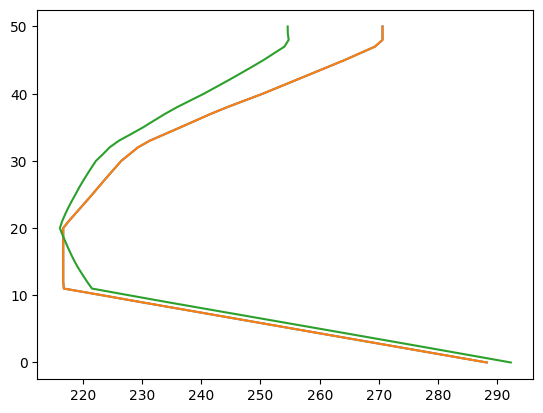

In [170]:
#With a perfect energy input from latent heat
sigma = 5.670374419e-8
E_perf=(M*sigma)@T_real**4 ### The perfect fit . It works with the function 

def solve_fit_atmosphere(E_perf,M):
    sigma = 5.670374419e-8
    Q=np.linalg.solve(M,E_perf)
    T=abs((Q/sigma))**0.25
    return Q,T


Q,T=solve_fit_atmosphere(E_perf,M)
plt.plot(T,z_interp*1e-3,label='Fitted atmosphere')
plt.plot(T_real,z_interp*1e-3,label='Real atmosphere')
print(E_perf)

#Doubble CO2
eps_mean_layer_2xCO2,eps_layer_2xCO2=eps_grey_com(z_interp, mid_Treal, mid_air, CO2ppm*2,mid_H2Oppm, alpha_CO2, alpha_H2O, Band_interval, planck_spec)
eps_mean_layer_2xCO2=np.concatenate(([1],eps_mean_layer_2xCO2)) #add surface and space
M_2xCO2=N_layer_system(eps_mean_layer_2xCO2)
Q_2xCO2,T_2xCO2=solve_fit_atmosphere(E_perf,M_2xCO2)
plt.plot(T_2xCO2,z_interp*1e-3,label='2xCO2 fitted atmosphere')


print(np.sum(E_perf))
print(T_2xCO2-T)

240.0
294.6817748506289
96.00000000000001 144.0
240.0
[144.          16.95420966   7.18057486   4.54468835   4.07363374
   3.8426872    3.21118258   2.05663474   0.4357878   -1.54540467
   0.           0.           0.           0.50947152   1.48962053
   1.96203306   2.20471      2.29744355   2.31378117   2.26691398
   2.16647021   2.19492862   2.18801156   2.14396415   2.06768767
   1.97192032   1.8861688    1.78311702   1.66874302   1.571893
   1.46706022   1.37505073   1.29463652   1.23703896   1.21618851
   1.19843874   1.19004415   1.18089005   1.16217009   1.14179449
   1.1060572    1.06562244   1.03539037   0.99546189   0.95820276
   0.91625287   0.87197345   0.83431636   0.78678206   0.76271654
   0.76303917]


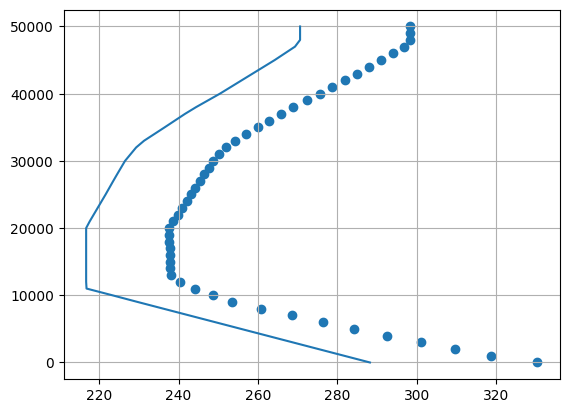

In [171]:
#add constraints.
#1 all energys negative, 2 E sum= E_in_total (240 W/m^2) and max RL 0.4

#Chat helped me doing this. Own code

#First optimal


#Scale to 240 W/^2 # adjust to atmospheric case
E_in_tot=240
RL=0.40
E_scale=E_perf/np.sum(E_perf)*E_in_tot

print(np.sum(E_scale))
#constraint Ratio
if E_scale[0] <E_in_tot*(1-RL):
    E_scale[0]=E_in_tot*(1-RL)



E_adjust=E_scale[1:]


#make a mask for posetive values.
mask=E_adjust<0
#Count true values
n_pos=np.sum(~mask)

E_adjust[mask]=0

print(np.sum(E_adjust)+E_scale[0])

S=E_in_tot-E_scale[0]
Step_size=(np.sum(E_adjust)-S)/n_pos
#make step_size into arary with the mask
Step_size_array=np.zeros_like(E_adjust)

#Scale step_size to epsilon values
step_tot=n_pos*Step_size
#Scale eps[1:] to sum=1

step_scale=eps_mean_layer[1:][~mask]/np.sum(eps_mean_layer[1:][~mask]) # Make scaled version as eps.

Step_size_array[~mask]=step_scale*step_tot #Change energy input proportional to eps 

E_adjust=E_adjust-Step_size_array #Calc one step change

print(np.sum(E_adjust),E_scale[0])

E_final=np.concatenate(([E_scale[0]],E_adjust))

print(np.sum(E_final))
print(E_final)

Q,T=solve_fit_atmosphere(-E_final,M)



#plot profile

plt.scatter(T,z_interp)
plt.plot(T_real,z_interp)
plt.grid()






239.88428180138425


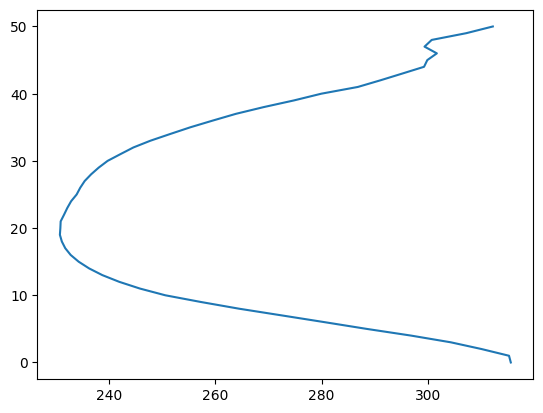

In [172]:
from E_in_Ozone import Ozone_absorption_constant_253K_P, Sun_E_bands,E_abs_O
file="Spectra/Ozone_spectrum.csv"
Bandends=[220,1100]
Bandwidth=10
band_interval_O, absorptivity_interval_mean = Ozone_absorption_constant_253K_P(file,Bandends, Bandwidth)
E_bands = Sun_E_bands(band_interval_O)

E_abs_height=E_abs_O(E_bands, absorptivity_interval_mean, band_interval_O, O3_interp, z_interp, dz=1000)

Rl=0.8
E_surface=E_in_tot-np.sum(E_abs_height)
EL=E_surface*Rl

L= np.array([0,EL*0.28,EL*0.20,EL*0.18,EL*0.13,EL*0.08,EL*0.06,EL*0.04,EL*0.02,EL*0.01,0]) #Decreasing energy transfer
L=np.concatenate((L,np.zeros(int(len(z_interp)-len(L)))))
E=L+E_abs_height
E[0]=E_surface*(1-Rl)
print(np.sum(E))

Q,T=solve_fit_atmosphere(-E,M)
plt.plot(T,z_interp*1e-3,label='With latent heat input')

[1.     0.1276 0.2244 0.3422 0.3837 0.3572 0.3367 0.2745 0.1532 0.0514
 0.0235 0.037 ]
239.74999999999997
235.58317451536143
[302.88249644 287.30760504 284.00544029 278.14981968 269.48479735
 259.44212605 248.63543849 237.23322071 227.24633883 224.06021896
 230.06443891 250.36005568]


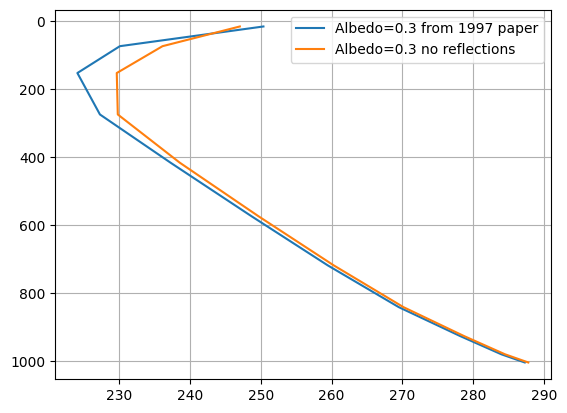

In [173]:
#Match other result from 1D paper.
Layer = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
P = np.array([1004, 980, 926, 841, 718, 573, 416, 274, 152, 73, 15])
dP = np.array([22, 39, 69, 104, 134, 151, 150, 132, 101, 69, 44])
T = np.array([286, 285, 281, 276, 268, 257, 242, 222, 205, 204, 223])
q = np.array([9.130, 8.857, 7.739, 5.285, 2.747, 1.292, 0.393, 0.063, 0.010, 0.009, 0.006])
O3 = np.array([5.68E-5, 1.11E-4, 2.28E-4, 4.43E-4, 8.44E-4, 1.65E-3, 3.38E-3, 7.41E-3, 1.67E-2, 3.92E-2, 1.59E-1])
t = np.array([0.8724, 0.7756, 0.6578, 0.6163, 0.6428, 0.6633, 0.7255, 0.8468, 0.9486, 0.9765, 0.9630])
tau = np.array([0.9930, 0.9868, 0.9745, 0.9635, 0.9572, 0.9522, 0.9587, 0.9773, 0.9874, 0.9897, 0.9720])
#tau=np.array([0.9620, 0.98, 0.9745, 0.9635, 0.9572, 0.9522, 0.9587, 0.9773, 0.9874, 0.9897, 0.9720])#snyd.
rho = np.array([1.98e-3, 3.77e-3, 7.17e-3, 1.13e-2, 1.43e-2, 1.61e-2, 1.51e-2, 1.13e-2, 7.77e-3, 5.25e-3, 5.37e-3])

###
eps=np.ones(len(t))-t

#add surface eps=1
eps=np.concatenate(([1],eps))
print(eps)

#equilent to Ozone absorbtion. See differnce from reflexions below.
E_SW_in=1370*0.7/4
E_SW=np.zeros(len(eps)-1)
for i in range(1,len(eps)):
    E_SW[-i]=E_SW_in*(1-tau[-i])#tau is transmissity of shortwave
    E_SW_in+=-E_SW_in*(1-tau[-i])

E_1D_tau=np.concatenate(([E_SW_in],E_SW))
#print(np.sum(E_1D))



def compute_energy_absorbed(S, rho, tau, albedo=0.3):

   
    n = len(tau)
    tau = np.array(tau)
    rho = np.array(rho)
    
    # Energy reaching the ground (surface)
    E0 = (S / 4) * (1 - albedo) * np.prod(tau)
    
    Ei = np.zeros(n)
    
    # Loop for atmospheric layers i 
    for i in range(n):
        prod_upper = np.prod(tau[i+1:])  # product from layer i+1 → n
        
        # Inner sum term
        
        
        Ei[i] = (S / 4) * prod_upper * (1 - tau[i] - rho[i])
    
    return E0, Ei


S=1370
#rho=rho[::-1]
#tau=tau[::-1]

E0, Ei = compute_energy_absorbed(S, rho, tau)
E_1D=np.concatenate(([E0],Ei))
print(np.sum(E_1D_tau))
print(np.sum(E_1D))

M=N_layer_system(eps)
Q,T=solve_fit_atmosphere(-E_1D,M)

Q_tau,T_tau=solve_fit_atmosphere(-E_1D_tau,M)
plt.plot(T[1:],P, label='Albedo=0.3 from 1997 paper')
plt.plot(T_tau[1:],P, label='Albedo=0.3 no reflections')
plt.legend()
plt.gca().invert_yaxis()
plt.grid()
print(T)




(11,) (12,)


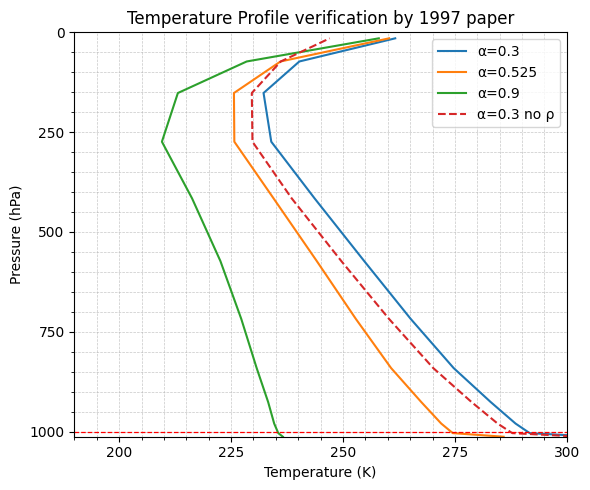

258.2583881564587
[306.34297202 291.69478796 288.53483009 282.9690674  274.70975993
 265.12813082 254.73407011 243.65256266 233.97178762 232.24869832
 240.24153798 261.6595548 ]
0.24596091049209146 Real albedo


In [174]:
import numpy as np

SIGMA = 5.670374419e-8  # Stefan–Boltzmann (W m^-2 K^-4)

# ---------- 1) Longwave matrix K (surface is index 0) ----------
def build_K_from_longwave_t(t_lw):
    """
    t_lw: 1D array of longwave transmissivities for layers 1..n (bottom→top).
    Returns (n+1)×(n+1) symmetric K.
    """
    t = np.asarray(t_lw, dtype=float)
    n = len(t)
    K = np.zeros((n+1, n+1), float)

    # Surface row/col
    K[0, 0] = -1.0
    K[0, 1] = (1 - t[0]); K[1, 0] = K[0, 1]
    for j in range(2, n+1):
        K[0, j] = (1 - t[j-1]) * np.prod(t[:j-1])
        K[j, 0] = K[0, j]

    # Atmosphere block
    for i in range(1, n+1):
        K[i, i] = -2.0 * (1 - t[i-1])
    for i in range(1, n):
        val = (1 - t[i-1]) * (1 - t[i])
        K[i, i+1] = val; K[i+1, i] = val
    for i in range(1, n):
        for j in range(i+2, n+1):
            val = (1 - t[i-1]) * (1 - t[j-1]) * np.prod(t[i:j-1])
            K[i, j] = val; K[j, i] = val
    return K

# ---------- 2) Shortwave RHS E (Eq. like in your image) ----------
def build_E_shortwave(S, tau_sw, rho_sw_atm, albedo=0.30):
    """
    S: solar constant (e.g., 1361)
    tau_sw: shortwave transmissivities τ_i for layers 1..n (bottom→top)
    rho_sw_atm: shortwave reflectivities ρ_i for layers 1..n
    albedo: surface (planetary) albedo ρ_0
    Returns E (length n+1): [E0, E1..En]
    """
    tau = np.asarray(tau_sw, float)
    rho = np.asarray(rho_sw_atm, float)
    n = len(tau)
    E = np.zeros(n+1, float)

    # E0 (surface)
    E[0] = (S/4.0) * (1 - albedo) * np.prod(tau)

    # Ei, i = 1..n
    for i in range(1, n+1):
        prod_upper = np.prod(tau[i:])       # ∏_{l=i+1..n} τ_l  (empty prod → 1)
        ti = tau[i-1]
        ri = rho[i-1]

        inner_sum = 0.0
        # l = 0..i-1  (with ρ_0 = albedo)
        for l in range(0, i):
            rl = (albedo if l == 0 else rho[l-1])
            # ∏_{m=l+1..i-1} τ_m^2  (empty prod → 1)
            if i - (l+1) >= 1:
                prod_inner = np.prod(tau[l:i-1])**2
            else:
                prod_inner = 1.0
            inner_sum += rl * prod_inner

        E[i] = (S/4.0) * prod_upper * (1 - ti - ri + ti*(1 - ti)*inner_sum)

    return E

# ---------- 3) Solver: K Q = -E, then T = (Q/σ)^(1/4) ----------
def solve_radiative_equilibrium(S, t_lw, tau_sw, rho_sw_atm, albedo=0.30, sigma=SIGMA):
    """
    Returns dict with K, E, Q, T, residual.
    """
    K = build_K_from_longwave_t(t_lw)
    E = build_E_shortwave(S, tau_sw, rho_sw_atm, albedo)

    # Solve K Q = -E
    try:
        Q = np.linalg.solve(K, -E)
    except np.linalg.LinAlgError:
        # fallback if near-singular (shouldn't happen with sensible t)
        Q = np.linalg.lstsq(K, -E, rcond=None)[0]

    # Convert to temperatures; guard against tiny negative noise
    Q = np.maximum(Q, 0.0)
    T = (Q / sigma)**0.25

    resid = K @ Q + E
    return T,K,E
T,K,E_chat=solve_radiative_equilibrium(1370,t,tau,rho,albedo=0.3)
Q,T_my=solve_fit_atmosphere(-E_chat,K)
#plt.plot(T[1:],P) # The same

T,K,E_chat_mid=solve_radiative_equilibrium(1370,t,tau,rho,albedo=0.525)
Q,T_my_mid=solve_fit_atmosphere(-E_chat_mid,K)

T,K,E_chat_cold=solve_radiative_equilibrium(1370,t,tau,rho,albedo=0.9)
Q,T_my_cold=solve_fit_atmosphere(-E_chat_cold,K)

plt.figure(figsize=(6, 5))

P_re=np.concatenate(([1013],P)) #add surface pressure
print(P.shape,T_my.shape)
plt.plot(T_my, P_re, label='α=0.3')
plt.plot(T_my_mid, P_re, label='α=0.525')
plt.plot(T_my_cold, P_re, label='α=0.9')
#black with stripes without rho
plt.plot(T_tau,P_re, label='α=0.3 no ρ', linestyle='--')
# Axis limits
plt.xlim(190, 300)
plt.ylim(0, 1013)
plt.gca().invert_yaxis()

# Create fine tick marks
x_ticks_minor = np.arange(190, 301, 5)
x_ticks_major = np.arange(200, 301, 25)
y_ticks_minor = np.arange(0, 1013, 50)
y_ticks_major = np.arange(0, 1013, 250)

# Apply ticks
plt.xticks(x_ticks_major)
plt.yticks(y_ticks_major)
plt.gca().set_xticks(x_ticks_minor, minor=True)
plt.gca().set_yticks(y_ticks_minor, minor=True)

# Grid and labels
#Insert thin red line at P=1000 hPa
plt.axhline(1000, color='red', linestyle='--', linewidth=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.minorticks_on()

plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (hPa)')
plt.title('Temperature Profile verification by 1997 paper')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
print(np.sum(E_chat))
print(T_my)
print(1-(np.sum(E_chat))/(1370/4), "Real albedo")

[[-1.50000000e+00  5.51308114e-01  2.30864104e-01 ...  4.37283513e-06
   4.23227123e-06  4.22735907e-06]
 [ 1.05130811e+00 -3.00261623e+00  2.83662927e-01 ...  5.37290636e-06
   5.20019537e-06  5.19415980e-06]
 [ 2.30864104e-01  2.18366293e+00 -1.02905406e+00 ...  1.03289941e-05
   9.99697068e-06  9.98536777e-06]
 ...
 [ 4.37283513e-06  5.37290636e-06  1.03289941e-05 ... -2.39550755e-03
   1.39016379e-06  1.38855031e-06]
 [ 4.23227123e-06  5.20019537e-06  9.99697068e-06 ...  1.39016379e-06
  -2.32128477e-03  1.34709074e-06]
 [ 4.22735907e-06  5.19415980e-06  9.98536777e-06 ...  1.38855031e-06
   1.34709074e-06 -2.32128477e-03]]


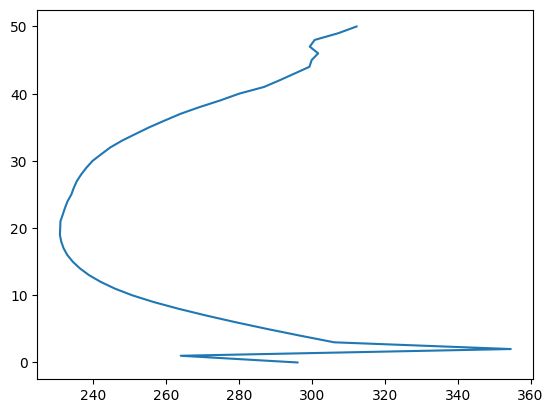

In [175]:
import math
def N_layer_system_convective(Eps,c): #Eps[0]=1 to work properly
    Eps[0]=1
    N=len(Eps)
    t=1-Eps
    accuracy=1e-7
    # Epsilon cant be 1 or 0, singular matrix otherwise 
    for i in range(len(Eps)-1):
        if (Eps[i+1]<=accuracy):
            Eps[i+1]=accuracy
        elif (Eps[i+1]>=1-accuracy):
            Eps[i+1]=1-accuracy
            
    M=[]
    for n in range(N): #number of rows
        row = np.zeros(N)
        for i in range(N): #making the columns.
            
            if i > n:
                row[i]=math.prod(t[n+1:i])*Eps[i]*Eps[n] #multiplying the Epsilons together between each transmission layer
                if i-n == 1:
                    row[i]=Eps[i-1]*Eps[i]
            elif n == 0 and i == 0:
                row[i]=(-1)*Eps[i]
            
            elif i == n and n!=0:
                row[i]=(-2)*Eps[i]
            
            
        M.append(row)
    M=np.array(M)   

    #It is symetric so make M[1][0] = M[0][1] and so on.
    #I transpose the matrix and add it to itself and then subtract the diagonal.
    M_transpose = np.transpose(M)
    M = np.array(M) + M_transpose - np.diag(np.diag(M))
    MM=M.copy()
    for i in range(N-1):#Add convective coefficients
        M[i,i]=M[i,i]+c[i]
        M[i+1,i]=M[i+1,i]-c[i]
    return M,MM


c=np.array([-0.5,-1.9])
ones=np.zeros(len(z_interp)-len(c))
c=np.concatenate((c,ones))


M,MM=N_layer_system_convective(eps_mean_layer,c)
#print(MM)
print(M)
E_in_con=E_abs_height
E_in_con[0]=E_in_tot-np.sum(E_abs_height)+E_abs_height[0]

Q,T=solve_fit_atmosphere(-E_in_con,M)

plt.plot(T,z_interp*1e-3,label='With convection')
